In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier   
from scipy.stats import zscore
import joblib
import shap
import lime
from eli5.sklearn import PermutationImportance
import dice_ml
from dice_ml import Dice
import pandas as pd

### Dataset Analisys

In [71]:
df=pd.read_csv('heart.csv', encoding='latin1')
df
print("Dataset information:")
df.info()
print("Duplicates row: "+str(df.duplicated().sum()))


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
Duplicates row: 0


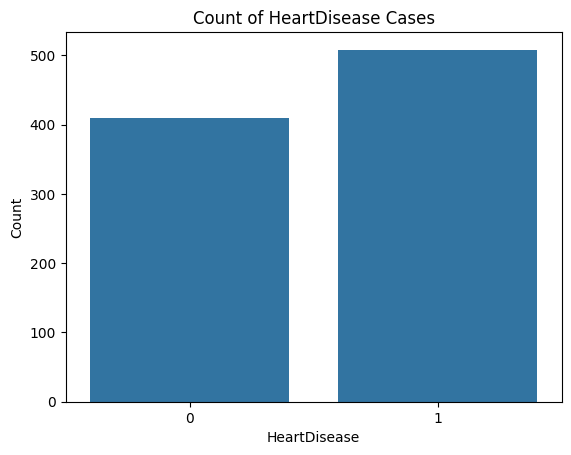

In [72]:
sns.countplot(x='HeartDisease', data=df)
plt.title('Count of HeartDisease Cases')
plt.xlabel('HeartDisease')
plt.ylabel('Count')
plt.show()

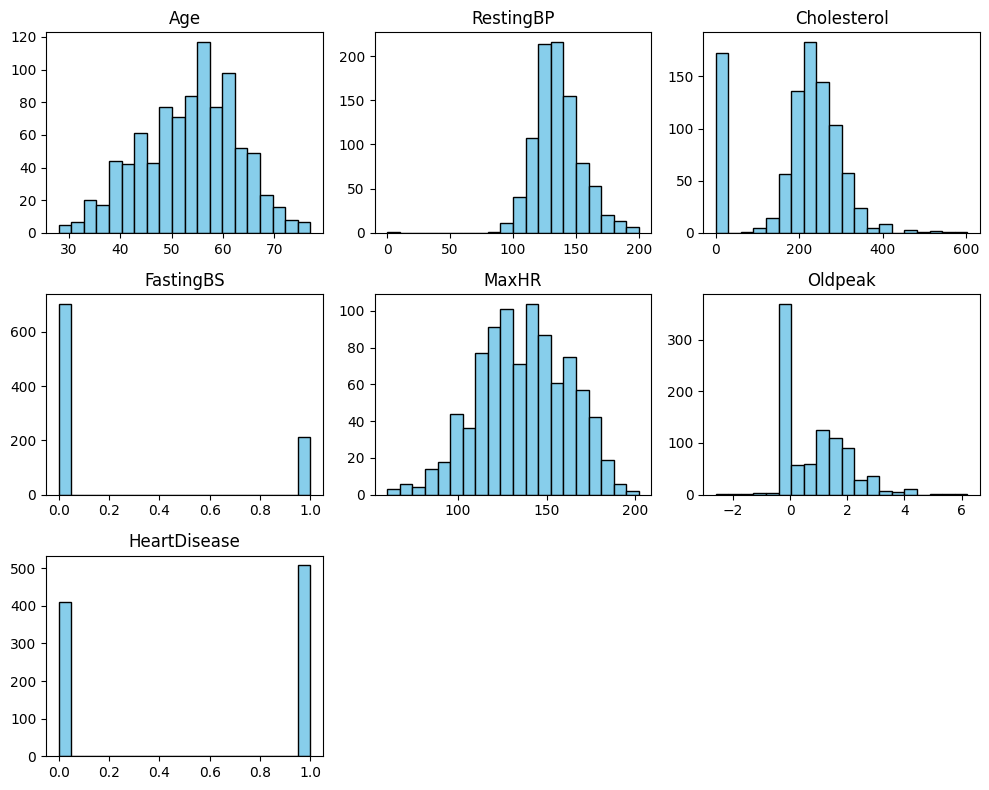

In [73]:
numeric_columns = df.select_dtypes(include='number').columns

plt.figure(figsize=(10, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    plt.hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(column)
    plt.tight_layout()

plt.show()

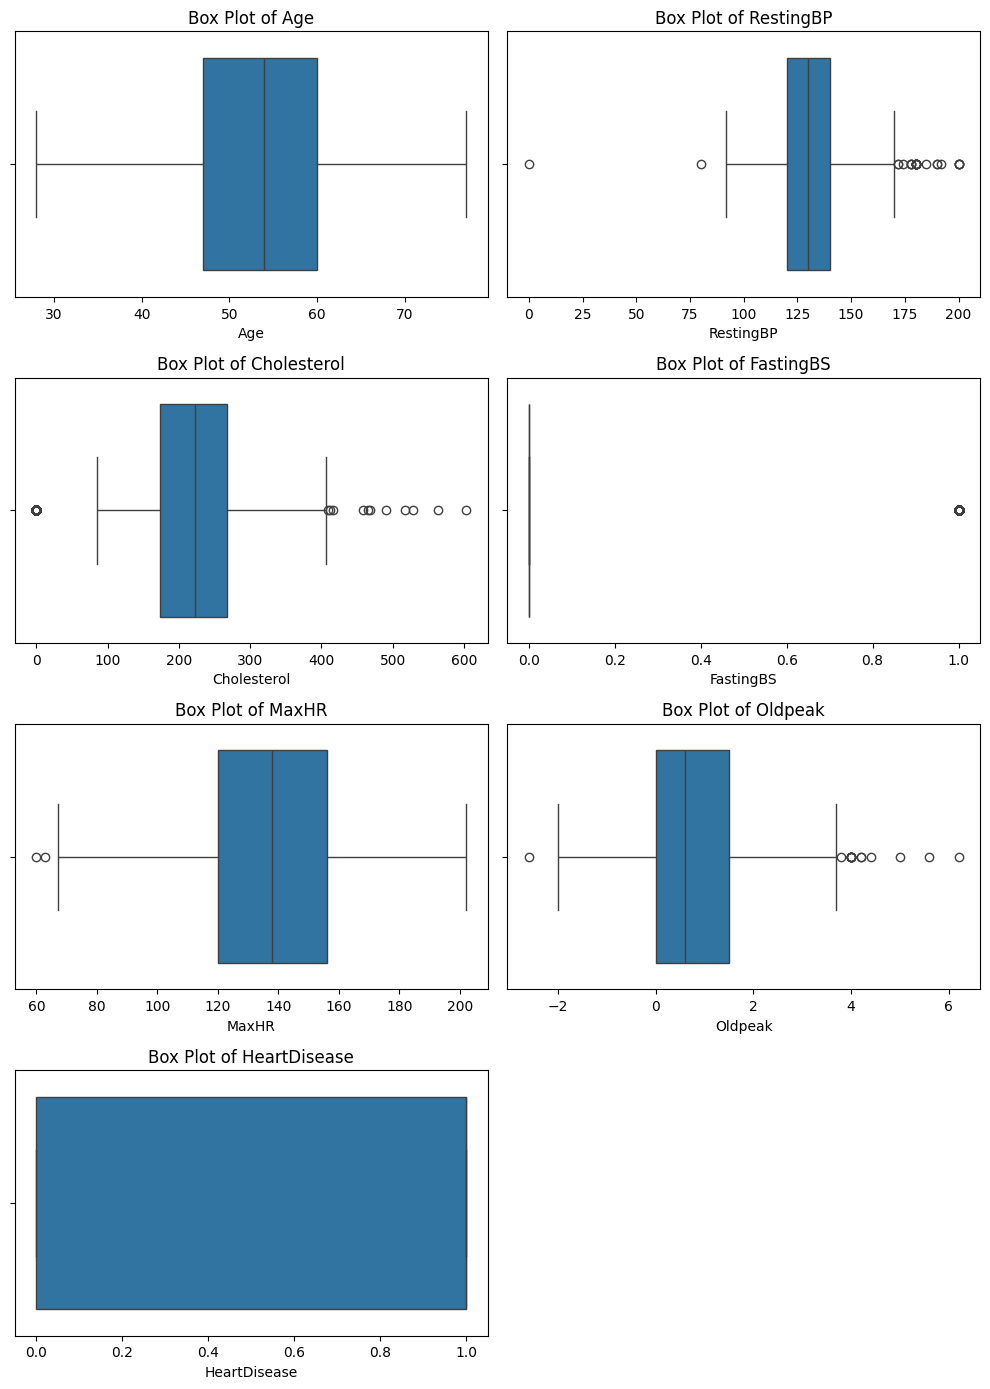

In [74]:
plt.figure(figsize=(10, len(numeric_columns)*2))

for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns)//2 + 1, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

HeartDisease_coor
Oldpeak        0.403951
Age            0.282039
FastingBS      0.267291
RestingBP      0.107589
Cholesterol   -0.232741
MaxHR         -0.400421
Name: HeartDisease, dtype: float64


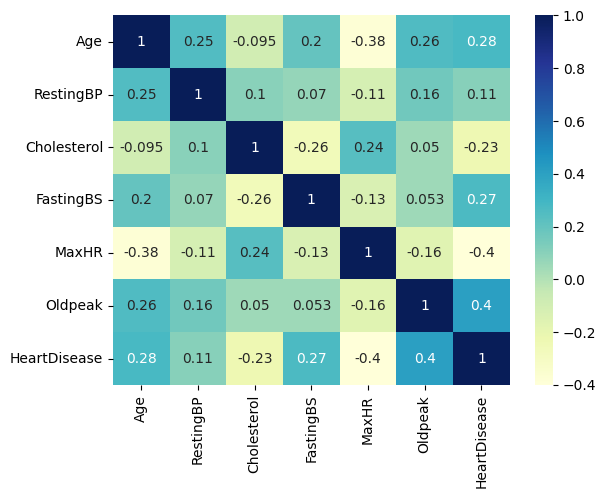

In [75]:
correlation = df.corr(numeric_only=True)['HeartDisease'].sort_values(ascending=False)

print("HeartDisease_coor")
print(correlation[1::])

new_columns=df.select_dtypes(include=['number'])
sns.heatmap(new_columns.corr(),cmap='YlGnBu',annot=True)
plt.show()

### Removing outliers with Z-Score

In [76]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
z_scores = df[numeric_cols].apply(zscore)
mask = (z_scores < 3).all(axis=1) & (z_scores > -3).all(axis=1)
df = df[mask]
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### Standardization and One Hot Encoding

In [77]:
scaler = StandardScaler()
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

string_columns = df.select_dtypes(include=['object']).columns
encoded_df = pd.DataFrame()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

for col in string_columns:
    encoded = encoder.fit_transform(df[[col]])
    cols = encoder.get_feature_names_out([col])
    encoded_part = pd.DataFrame(encoded, columns=cols, index=df.index)
    encoded_df = pd.concat([encoded_df, encoded_part], axis=1)

df = df.drop(columns=string_columns)
df = pd.concat([df, encoded_df], axis=1)

df.head()
y=df['HeartDisease']
x=df.drop(columns=['HeartDisease'], errors='ignore')

### Split the dataset 

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Training the model


Training...


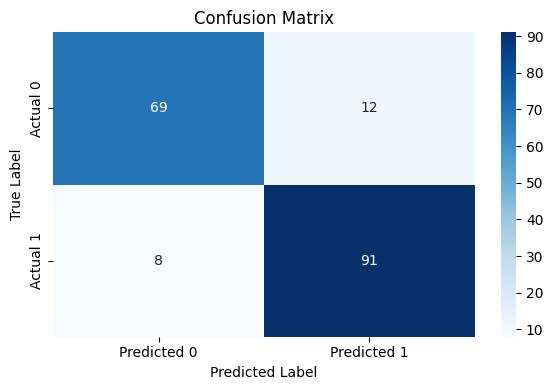


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.85      0.87        81
           1       0.88      0.92      0.90        99

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180



In [79]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

print(f"\nTraining...")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

labels = np.unique(y_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
conf_matrix_df = pd.DataFrame(conf_matrix, 
                                columns=[f"Predicted {label}" for label in labels], 
                                index=[f"Actual {label}" for label in labels])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred))

### Save the model

In [80]:
joblib.dump(model, 'heart_disease_model.pkl')

['heart_disease_model.pkl']

### SHAP Explanation

<Figure size 640x480 with 0 Axes>

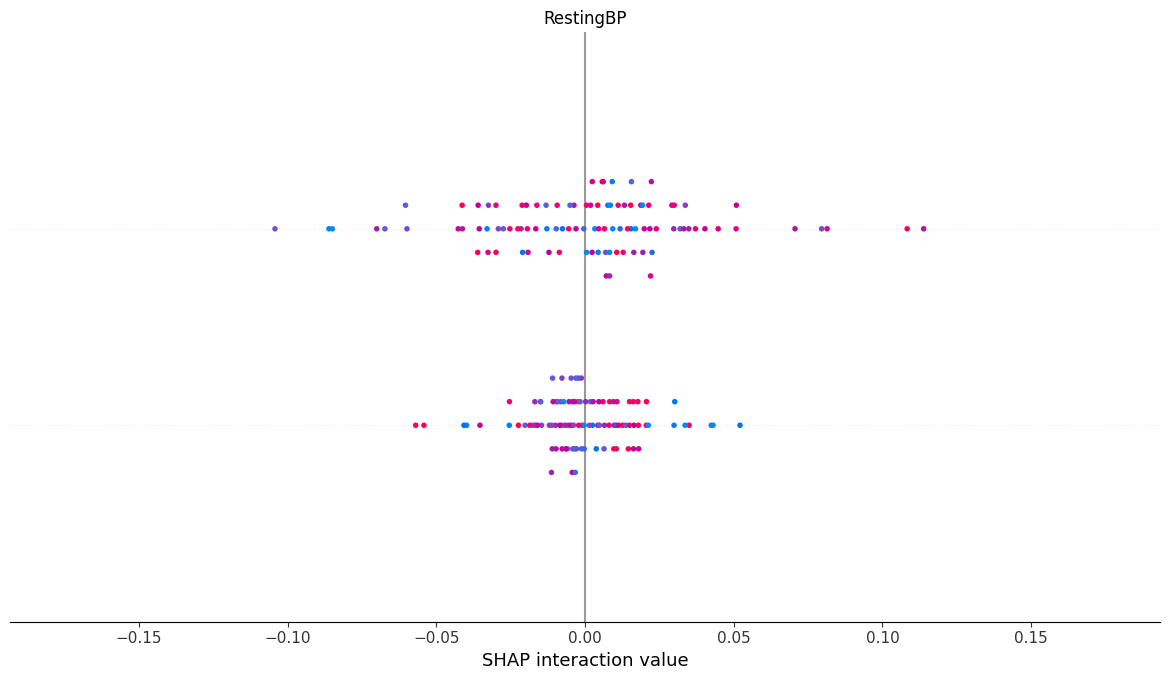

In [ ]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test[:100], check_additivity=False)

shap.summary_plot(shap_values, x_test[:100])

### LIME Explanation

In [ ]:
# Create Lime explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification'
)

# Explain a prediction
i = 0  # Index of the instance to explain
exp = lime_explainer.explain_instance(x_test.iloc[i].values, model.predict_proba, num_features=10)

# Show explanation
exp.show_in_notebook(show_table=True)

c:\Users\gioel\anaconda3\envs\heart_attack\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Permutation Importance (ELI5)

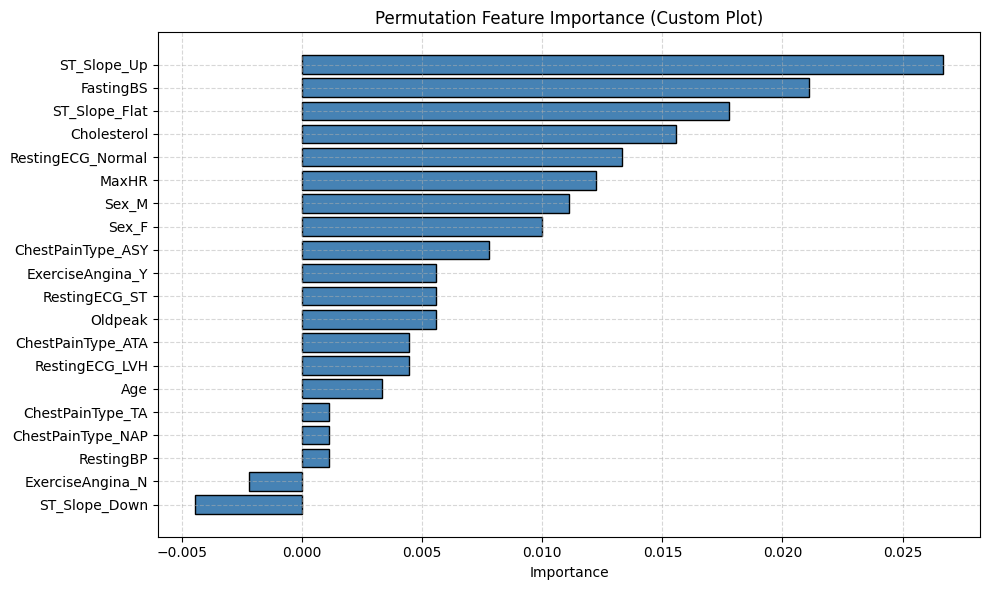

In [ ]:
# Calcolo dell'importanza
perm = PermutationImportance(model, random_state=42)
perm.fit(x_test, y_test)

# Estraggo i pesi e le feature
weights = perm.feature_importances_
features = x_test.columns

# Ordino per importanza
sorted_idx = np.argsort(weights)
features_sorted = features[sorted_idx]
weights_sorted = weights[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, weights_sorted, color='steelblue', edgecolor='black')
plt.xlabel("Importance")
plt.title("Permutation Feature Importance (Custom Plot)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [82]:
# Create a data object
data_dice = dice_ml.Data(
    dataframe=pd.concat([x_train, y_train], axis=1),
    continuous_features=x_train.select_dtypes(include=['float', 'int']).columns.tolist(),
    outcome_name=y_train.name  # e.g., "target"
)

# Create model object
model_dice = dice_ml.Model(model=model, backend="sklearn")

# Initialize DiCE explainer
dice = Dice(data_dice, model_dice)

# Pick a test instance
query_instance = x_test.iloc[0:1]

# Generate counterfactuals (e.g., we want the opposite class)
cf = dice.generate_counterfactuals(query_instance, total_CFs=2, desired_class="opposite")

# Visualize results
cf.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

Query instance (original outcome : 0)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,0.0532,1.050307,0.317414,0,1.108106,1.6,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,0.0532,1.050307,0.317414,0,-0.341487,1.6,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,1
1,0.0532,1.050307,0.317414,0,1.108106,1.6,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.7,0.4,1
